In [1]:
from web3 import Web3
from solcx import install_solc, set_solc_version, compile_files
import time
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import random

# 连接 Ganache
w3 = Web3(Web3.HTTPProvider('http://localhost:8545'))
assert w3.is_connected(), "请确保 Ganache 已启动"
print(f"连接状态: {w3.is_connected()}")

# 安装 Solidity 编译器
install_solc('0.8.17')  # 安装与合约代码匹配的版本
set_solc_version('0.8.17')

连接状态: True


In [2]:
# 读取 Solidity 文件
solidity_file = '../contracts/FLIncentiveOptimized.sol'

with open(solidity_file, 'r') as f:
    contract_source = f.read()

# 显示文件内容（可选）
display(Markdown("### Solidity 合约源码"))
# print(contract_source)

### Solidity 合约源码

In [3]:
# 编译合约
compiled = compile_files(
    [solidity_file],  # 传入文件路径列表
    output_values=['abi', 'bin']
)

# 提取合约接口
contract_id, contract_interface = compiled.popitem()
bytecode = contract_interface['bin']
abi = contract_interface['abi']

# 显示编译结果
display(Markdown("### 编译结果"))
print(f"合约 ID: {contract_id}")
print(f"ABI: {abi[:100]}...")  # 显示 ABI 的前 100 个字符

### 编译结果

合约 ID: /Users/y.wang8uva.nl/Library/CloudStorage/OneDrive-UvA/TSC2025/reliableFLOps/fl-incentive-ganache/contracts/FLIncentiveOptimized.sol:FLIncentiveOptimized
ABI: [{'inputs': [{'internalType': 'uint256', 'name': '_deadline', 'type': 'uint256'}, {'internalType': 'uint256', 'name': '_gracePeriod', 'type': 'uint256'}, {'internalType': 'uint256', 'name': '_claimWindow', 'type': 'uint256'}, {'internalType': 'uint96[3][3]', 'name': '_stakeMatrix', 'type': 'uint96[3][3]'}, {'internalType': 'uint16[3][3]', 'name': '_multiplierMatrix', 'type': 'uint16[3][3]'}], 'stateMutability': 'payable', 'type': 'constructor'}, {'anonymous': False, 'inputs': [{'indexed': False, 'internalType': 'uint256', 'name': 'totalRewards', 'type': 'uint256'}], 'name': 'ContractFinalized', 'type': 'event'}, {'anonymous': False, 'inputs': [{'indexed': True, 'internalType': 'address', 'name': 'user', 'type': 'address'}, {'indexed': False, 'internalType': 'uint256', 'name': 'penalty', 'type': 'uint256'}], 'name': 'LatePe

In [4]:
# 部署参数
INITIAL_ETH = Web3.to_wei(100, 'ether')
DEADLINE = int(time.time()) + 3600  # 1小时后截止
GRACE_PERIOD = 600                  # 10分钟宽限期
CLAIM_WINDOW = 86400                # 24小时领取期

# 部署合约
fl_contract = w3.eth.contract(abi=abi, bytecode=bytecode)
tx_hash = fl_contract.constructor(
    DEADLINE,
    GRACE_PERIOD,
    CLAIM_WINDOW,
    [
        [Web3.to_wei(1, 'ether'), Web3.to_wei(2, 'ether'), Web3.to_wei(3, 'ether')],
        [Web3.to_wei(1.5, 'ether'), Web3.to_wei(2.5, 'ether'), Web3.to_wei(3.5, 'ether')],
        [Web3.to_wei(2, 'ether'), Web3.to_wei(3, 'ether'), Web3.to_wei(4, 'ether')]
    ],
    [
        [1000, 1500, 2000],
        [1200, 1800, 2500],
        [1500, 2000, 3000]
    ]
).transact({
    'from': w3.eth.accounts[0],
    'value': INITIAL_ETH
})
tx_receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
contract_address = tx_receipt['contractAddress']

# 显示部署结果
display(Markdown("### 部署结果"))
print(f"合约部署地址: {contract_address}")
print(f"交易哈希: {tx_hash.hex()}")
print(f"Gas 消耗: {tx_receipt['gasUsed']}")

### 部署结果

合约部署地址: 0x308A41271fBD49bF6E56D40232C15736D9D7B1f4
交易哈希: 0x99aa17582050634213b58d98c17ca381b5f5e6f304e2204abda66e1050e3e0d5
Gas 消耗: 2873675


In [5]:
# 加载合约实例
contract = w3.eth.contract(address=contract_address, abi=abi)

# 验证合约加载
display(Markdown("### 合约实例验证"))
print(f"当前合约阶段: {contract.functions.currentPhase().call()}")
print(f"初始资金池: {Web3.from_wei(contract.functions.currentPoolBalance().call(), 'ether')} ETH")

### 合约实例验证

当前合约阶段: 0
初始资金池: 100 ETH


### scenario#1 
#### 模拟用户根据本地数据选择合约项
每个用户将根据自己的本地数据类别和资源类别选择最接近的合约项。

In [6]:
# 模拟用户参与
num_users = 10
results = []

for i in range(num_users):
    user = w3.eth.accounts[i + 1]  # 使用不同账户
    
    # 随机生成用户的本地数据类别和资源类别
    local_data_cat = random.choice([0, 1, 2])  # 0=低, 1=中, 2=高
    local_resource_cat = random.choice([0, 1, 2])  # 0=低, 1=中, 2=高
    
    # 选择最接近的合约项
    data_cat = min(local_data_cat, 2)  # 确保不超过最高类别
    resource_cat = min(local_resource_cat, 2)  # 确保不超过最高类别
    
    stake = contract.functions.stakeMatrix(data_cat, resource_cat).call()
    
    try:
        # 用户加入合约
        tx_hash = contract.functions.join(data_cat, resource_cat).transact({
            'from': user,
            'value': stake
        })
        receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
        
        # 记录结果
        results.append({
            'user': user,
            'local_data_cat': local_data_cat,
            'local_resource_cat': local_resource_cat,
            'chosen_data_cat': data_cat,
            'chosen_resource_cat': resource_cat,
            'stake': Web3.from_wei(stake, 'ether'),
            'status': 'success',
            'tx_hash': tx_hash.hex()
        })
    except Exception as e:
        results.append({
            'user': user,
            'local_data_cat': local_data_cat,
            'local_resource_cat': local_resource_cat,
            'chosen_data_cat': data_cat,
            'chosen_resource_cat': resource_cat,
            'stake': Web3.from_wei(stake, 'ether'),
            'status': 'failed',
            'error': str(e)
        })

# 显示参与结果
df = pd.DataFrame(results)
display(Markdown("### 用户参与结果"))
display(df)

### 用户参与结果

,user,local_data_cat,local_resource_cat,chosen_data_cat,chosen_resource_cat,stake,status,tx_hash
0,0xf2d7f277Dce74d5bE37a48178d4FF8D8309F9a21,2,0,2,0,2,success,0x9bdd61bfe7dd2aa8997b0a3876b68993b5bc7065ed79...
1,0x9E6D037CD9cb77f91EA43247603C70b5d1055989,2,2,2,2,4,success,0x66c02c9f6f874b6a3ea0e7041fb4108af0f38bf3be0a...
2,0xB856Bb80a3dbda7854f8e1c5B1Db3B6EfD5cC027,2,2,2,2,4,success,0xcf415214b0cd9a504b69220bbc214dfc1b4dc6e40fcf...
3,0x6a6Cf08182c8277c3b1549246A759D17cE8306F4,1,1,1,1,2.5,success,0x9b2b7efb588cef0625c8d34fa4f31b65768d99b4551f...
4,0x0c24C1b5Be3e4678a4a1A8E29cCa3d2991a138BA,0,1,0,1,2,success,0x43b2fe3bd88d65b634f6ec477e2866e1c94a56698b02...
5,0x6090d0416759a93ECe56d9E0846Dd667D607376F,1,1,1,1,2.5,success,0x0584b03c55e1449e2b94183d99d4df662fe79d46221d...
6,0xab41b2c7446957114F2aB17Ebd8cBb4eA9724764,2,2,2,2,4,success,0x24930f5b7bd8183aecfeb0708e291db05527693ef8dd...
7,0xE98250c6aED9d6f35F50F2FE857fb545df4E5656,1,0,1,0,1.5,success,0xb9fd56deb47851f0a36cfb26ce0849e69c17eee41212...
8,0xFD95EA909487c417d1E059cD299D484161D95D70,0,2,0,2,3,success,0x1c27e20211caebbb180094c23b48f73b2547d38b272c...
9,0x6406d1A93CC7bC60e861F9F4edD3dCAAa0a541F0,2,2,2,2,4,success,0xa880a90fed0e4252b8f615857295ad3d65901f935e6b...


### 可视化分析
用户选择分布

/opt/anaconda3/envs/jupyterLab/analysis/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/jupyterLab/analysis/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/jupyterLab/analysis/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/jupyterLab/analysis/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/jupyterLab/analysis/lib/python3.12/site-

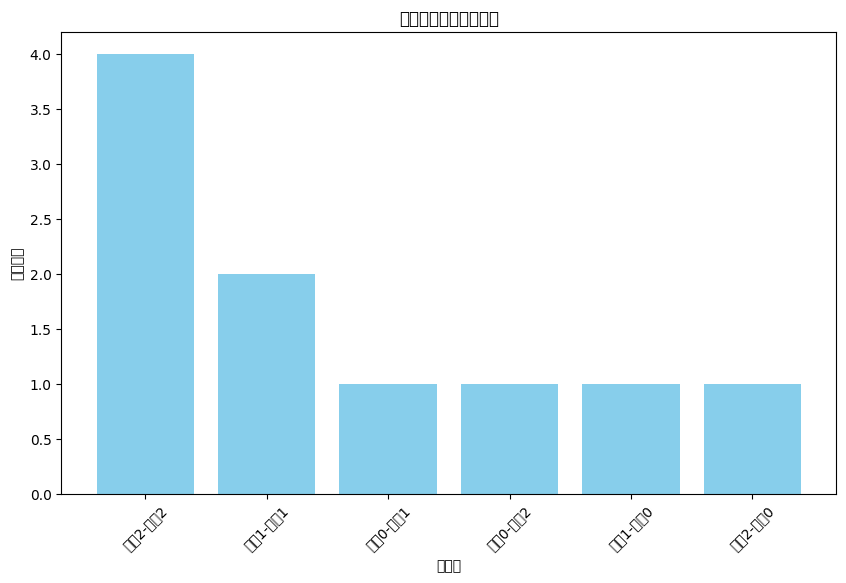

In [7]:
# 统计用户选择的合约项
choice_counts = df[['chosen_data_cat', 'chosen_resource_cat']].value_counts().reset_index()
choice_counts.columns = ['数据类别', '资源类别', '用户数量']

# 柱状图
plt.figure(figsize=(10, 6))
plt.bar(
    choice_counts.apply(lambda row: f"数据{row['数据类别']}-资源{row['资源类别']}", axis=1),
    choice_counts['用户数量'],
    color='skyblue'
)
plt.title("用户选择的合约项分布")
plt.xlabel("合约项")
plt.ylabel("用户数量")
plt.xticks(rotation=45)
plt.show()

本地数据与选择的对比

/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_25186/1983166555.py:20: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_25186/1983166555.py:20: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_25186/1983166555.py:20: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_25186/1983166555.py:20: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_25186/1983166555.py:20: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/8z/1cnk

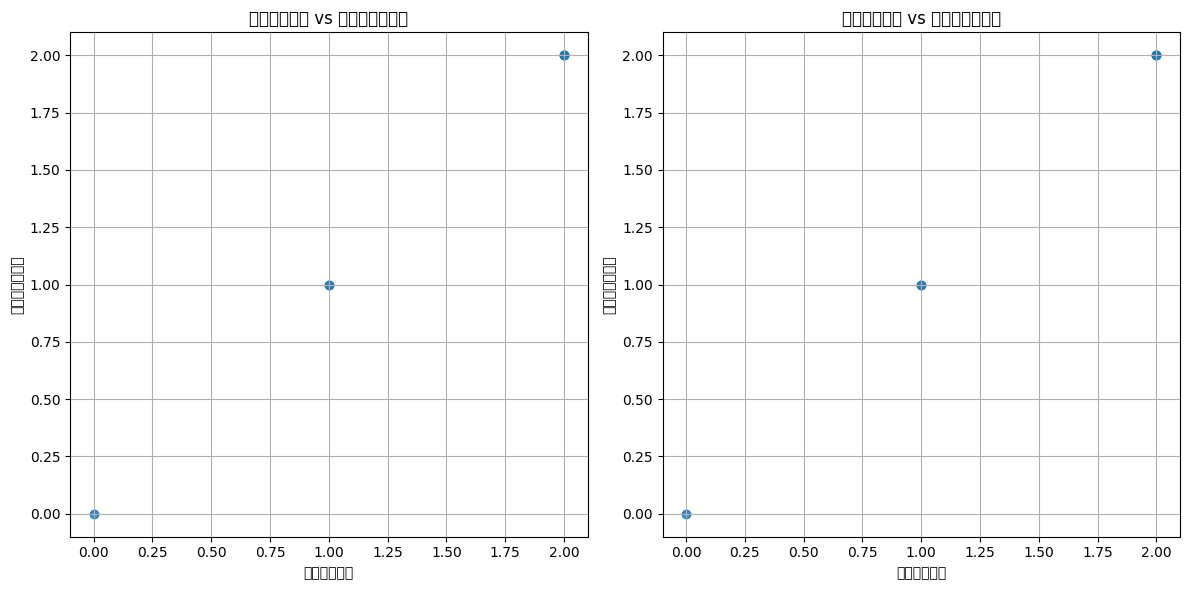

In [8]:
# 对比本地数据与选择的合约项
plt.figure(figsize=(12, 6))

# 本地数据类别
plt.subplot(1, 2, 1)
plt.scatter(df['local_data_cat'], df['chosen_data_cat'], alpha=0.6)
plt.title("本地数据类别 vs 选择的数据类别")
plt.xlabel("本地数据类别")
plt.ylabel("选择的数据类别")
plt.grid(True)

# 本地资源类别
plt.subplot(1, 2, 2)
plt.scatter(df['local_resource_cat'], df['chosen_resource_cat'], alpha=0.6)
plt.title("本地资源类别 vs 选择的资源类别")
plt.xlabel("本地资源类别")
plt.ylabel("选择的资源类别")
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
def get_financial_report():
    report = {
        '初始资金': Web3.from_wei(INITIAL_ETH, 'ether'),
        '当前资金池': Web3.from_wei(contract.functions.currentPoolBalance().call(), 'ether'),
        '总锁定资金': Web3.from_wei(contract.functions.totalLocked().call(), 'ether'),
        '待领取奖励': sum(
            Web3.from_wei(contract.functions.pendingRewards(acc).call(), 'ether')
            for acc in w3.eth.accounts[1:6]
        )
    }
    return pd.DataFrame([report]).T.rename(columns={0: 'ETH'})

display(Markdown("### 资金状态报告"))
display(get_financial_report())

### 资金状态报告

,ETH
初始资金,100
当前资金池,129.5
总锁定资金,129.5
待领取奖励,0


In [10]:
def get_financial_report():
    report = {
        '初始资金': Web3.from_wei(INITIAL_ETH, 'ether'),
        '当前资金池': Web3.from_wei(contract.functions.currentPoolBalance().call(), 'ether'),
        '总锁定资金': Web3.from_wei(contract.functions.totalLocked().call(), 'ether'),
        '待领取奖励': sum(
            Web3.from_wei(contract.functions.pendingRewards(acc).call(), 'ether')
            for acc in w3.eth.accounts[1:num_users + 1]
        )
    }
    return pd.DataFrame([report]).T.rename(columns={0: 'ETH'})

display(Markdown("### 资金状态报告"))
display(get_financial_report())

### 资金状态报告

,ETH
初始资金,100
当前资金池,129.5
总锁定资金,129.5
待领取奖励,0


In [11]:
import datetime as dt

# 时间旅行工具
def set_time(target_timestamp):
    """设置区块链时间并挖矿"""
    w3.provider.make_request('evm_setNextBlockTimestamp', [target_timestamp])
    w3.provider.make_request('evm_mine', [])

def get_current_phase():
    """获取当前合约阶段"""
    phases = ['ACTIVE', 'GRACE', 'CLOSED']
    return phases[contract.functions.currentPhase().call()]

# 交互式时间设置
from ipywidgets import interact, IntSlider

@interact(
    hours_before=IntSlider(min=-2, max=2, value=0, description='小时'),
    minutes=IntSlider(min=0, max=59, value=0, description='分钟')
)
def set_time_interactive(hours_before, minutes):
    offset = hours_before * 3600 + minutes * 60
    target_time = DEADLINE + offset
    set_time(target_time)
    print(f"当前时间: {dt.datetime.fromtimestamp(target_time)}")
    print(f"当前阶段: {get_current_phase()}")

interactive(children=(IntSlider(value=0, description='小时', max=2, min=-2), IntSlider(value=0, description='分钟'…

### 模拟用户选择行为
我们将模拟以下用户行为：

诚实用户：根据本地数据选择最接近的合约项。

随机用户：随机选择合约项。

夸大用户：选择比自己实际能力更高的合约项。

保守用户：选择比自己实际能力更低的合约项。

In [12]:
# 模拟用户参与
num_users = 10
results = []

for i in range(num_users):
    user = w3.eth.accounts[i + 1]  # 使用不同账户
    
    # 随机生成用户的本地数据类别和资源类别
    local_data_cat = random.choice([0, 1, 2])  # 0=低, 1=中, 2=高
    local_resource_cat = random.choice([0, 1, 2])  # 0=低, 1=中, 2=高
    
    # 随机分配用户行为
    behavior = random.choice(['诚实', '随机', '夸大', '保守'])
    
    if behavior == '诚实':
        # 选择最接近的合约项
        data_cat = min(local_data_cat, 2)
        resource_cat = min(local_resource_cat, 2)
    elif behavior == '随机':
        # 随机选择合约项
        data_cat = random.choice([0, 1, 2])
        resource_cat = random.choice([0, 1, 2])
    elif behavior == '夸大':
        # 选择比自己实际能力更高的合约项
        data_cat = min(local_data_cat + 1, 2)
        resource_cat = min(local_resource_cat + 1, 2)
    elif behavior == '保守':
        # 选择比自己实际能力更低的合约项
        data_cat = max(local_data_cat - 1, 0)
        resource_cat = max(local_resource_cat - 1, 0)
    
    stake = contract.functions.stakeMatrix(data_cat, resource_cat).call()
    
    try:
        # 用户加入合约
        tx_hash = contract.functions.join(data_cat, resource_cat).transact({
            'from': user,
            'value': stake
        })
        receipt = w3.eth.wait_for_transaction_receipt(tx_hash)
        
        # 记录结果
        results.append({
            'user': user,
            'behavior': behavior,
            'local_data_cat': local_data_cat,
            'local_resource_cat': local_resource_cat,
            'chosen_data_cat': data_cat,
            'chosen_resource_cat': resource_cat,
            'stake': Web3.from_wei(stake, 'ether'),
            'status': 'success',
            'tx_hash': tx_hash.hex()
        })
    except Exception as e:
        results.append({
            'user': user,
            'behavior': behavior,
            'local_data_cat': local_data_cat,
            'local_resource_cat': local_resource_cat,
            'chosen_data_cat': data_cat,
            'chosen_resource_cat': resource_cat,
            'stake': Web3.from_wei(stake, 'ether'),
            'status': 'failed',
            'error': str(e)
        })

# 显示参与结果
df = pd.DataFrame(results)
display(Markdown("### 用户参与结果"))
display(df)

### 用户参与结果

,user,behavior,local_data_cat,local_resource_cat,chosen_data_cat,chosen_resource_cat,stake,status,error
0,0xf2d7f277Dce74d5bE37a48178d4FF8D8309F9a21,诚实,1,1,1,1,2.5,failed,execution reverted: VM Exception while process...
1,0x9E6D037CD9cb77f91EA43247603C70b5d1055989,夸大,2,0,2,1,3,failed,execution reverted: VM Exception while process...
2,0xB856Bb80a3dbda7854f8e1c5B1Db3B6EfD5cC027,夸大,1,2,2,2,4,failed,execution reverted: VM Exception while process...
3,0x6a6Cf08182c8277c3b1549246A759D17cE8306F4,随机,1,1,0,0,1,failed,execution reverted: VM Exception while process...
4,0x0c24C1b5Be3e4678a4a1A8E29cCa3d2991a138BA,随机,2,2,2,1,3,failed,execution reverted: VM Exception while process...
5,0x6090d0416759a93ECe56d9E0846Dd667D607376F,诚实,2,1,2,1,3,failed,execution reverted: VM Exception while process...
6,0xab41b2c7446957114F2aB17Ebd8cBb4eA9724764,诚实,2,1,2,1,3,failed,execution reverted: VM Exception while process...
7,0xE98250c6aED9d6f35F50F2FE857fb545df4E5656,保守,2,2,1,1,2.5,failed,execution reverted: VM Exception while process...
8,0xFD95EA909487c417d1E059cD299D484161D95D70,夸大,2,2,2,2,4,failed,execution reverted: VM Exception while process...
9,0x6406d1A93CC7bC60e861F9F4edD3dCAAa0a541F0,夸大,0,1,1,2,3.5,failed,execution reverted: VM Exception while process...


/opt/anaconda3/envs/jupyterLab/analysis/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/jupyterLab/analysis/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/jupyterLab/analysis/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/jupyterLab/analysis/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20026 (\N{CJK UNIFIED IDEOGRAPH-4E3A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/jupyterLab/analysis/lib/python3.12/site-

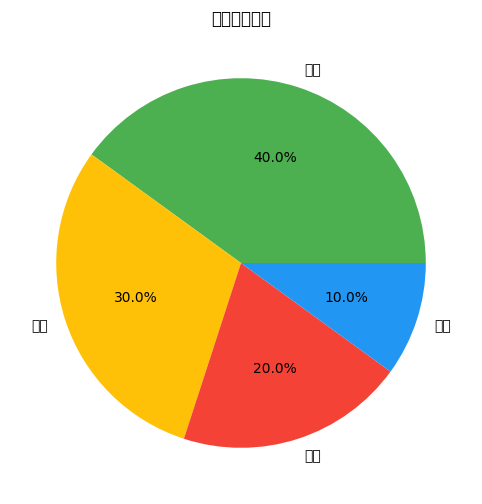

In [13]:
# 统计用户行为分布
behavior_counts = df['behavior'].value_counts()

# 饼状图
plt.figure(figsize=(8, 6))
plt.pie(
    behavior_counts,
    labels=behavior_counts.index,
    autopct='%1.1f%%',
    colors=['#4CAF50', '#FFC107', '#F44336', '#2196F3']
)
plt.title("用户行为分布")
plt.show()

/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_25186/1840523081.py:26: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_25186/1840523081.py:26: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_25186/1840523081.py:26: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_25186/1840523081.py:26: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/8z/1cnkmz4s4233_90z9hks3tbr0000gn/T/ipykernel_25186/1840523081.py:26: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/8z/1cnk

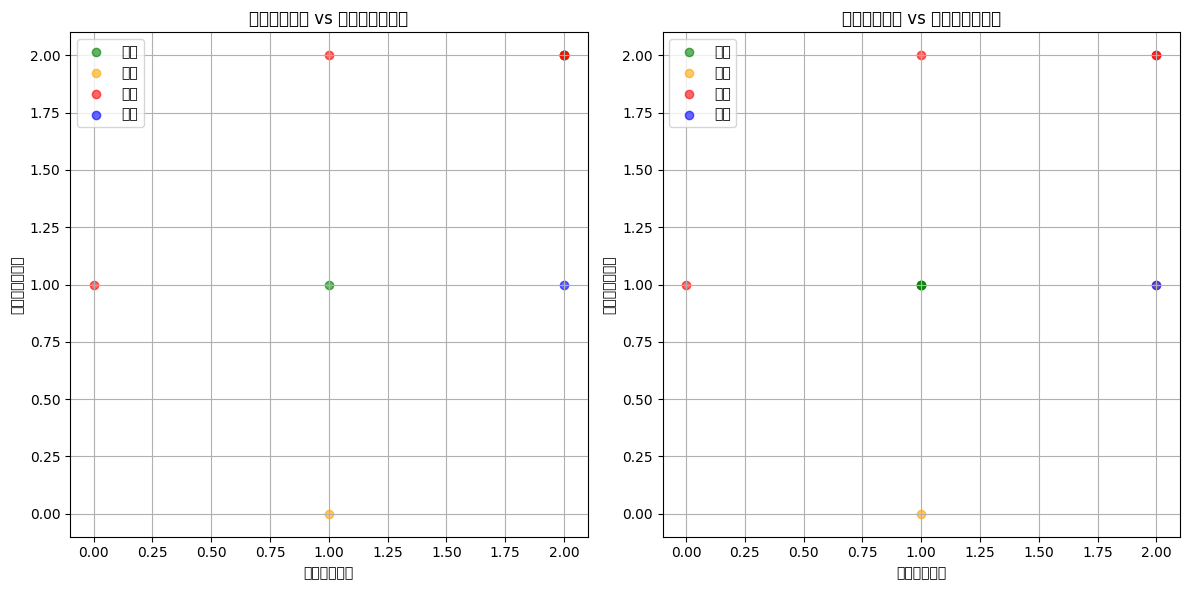

In [14]:
# 对比用户选择与本地数据
plt.figure(figsize=(12, 6))

# 数据类别
plt.subplot(1, 2, 1)
for behavior, color in zip(['诚实', '随机', '夸大', '保守'], ['green', 'orange', 'red', 'blue']):
    subset = df[df['behavior'] == behavior]
    plt.scatter(subset['local_data_cat'], subset['chosen_data_cat'], label=behavior, color=color, alpha=0.6)
plt.title("本地数据类别 vs 选择的数据类别")
plt.xlabel("本地数据类别")
plt.ylabel("选择的数据类别")
plt.legend()
plt.grid(True)

# 资源类别
plt.subplot(1, 2, 2)
for behavior, color in zip(['诚实', '随机', '夸大', '保守'], ['green', 'orange', 'red', 'blue']):
    subset = df[df['behavior'] == behavior]
    plt.scatter(subset['local_resource_cat'], subset['chosen_resource_cat'], label=behavior, color=color, alpha=0.6)
plt.title("本地资源类别 vs 选择的资源类别")
plt.xlabel("本地资源类别")
plt.ylabel("选择的资源类别")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def get_financial_report():
    report = {
        '初始资金': Web3.from_wei(INITIAL_ETH, 'ether'),
        '当前资金池': Web3.from_wei(contract.functions.currentPoolBalance().call(), 'ether'),
        '总锁定资金': Web3.from_wei(contract.functions.totalLocked().call(), 'ether'),
        '待领取奖励': sum(
            Web3.from_wei(contract.functions.pendingRewards(acc).call(), 'ether')
            for acc in w3.eth.accounts[1:num_users + 1]
        )
    }
    return pd.DataFrame([report]).T.rename(columns={0: 'ETH'})

display(Markdown("### 资金状态报告"))
display(get_financial_report())

### 资金状态报告

,ETH
初始资金,100
当前资金池,129.5
总锁定资金,129.5
待领取奖励,0


: 